 #   Regression ML - Stack Overflow 2018 Developer Survey

## Motivation: 
Strengthen the understanding of the basics of regression learning of data

## Data:

### Brief:
* Data set had been downloaded from: https://www.kaggle.com/stackoverflow/stack-overflow-2018-developer-survey
* The data includes 99k entries, of quistions answered by dev. over at SO
* we would like to predict the salary of a Dev. based on the parameters we will filter out of the dataset

### Data format:

#### Parameters/Features of a data point:
* Respondent - ID
* Hobby - yes/no - will will analyze only prof. devs
* OpenSource - yes/no
* Country
* student - yes/no part-time/full-time
* Employement type - full-type/Independant/etc.
* Formal Education - BSc/MSc/etc.
* UndergradMajor - CS/natural scoence/etc
* Company size
* Dev Type
* Yeats Coding
* Years Coding prof.
* Job satisfaction
* Career Satisfaction
* ConvertedSalary - yearly salary in USD
* LanguageWorkedWith
* OperatingSystem
* NumberMonitors
* WakeTime
* Exercise
* Gender
* Sexual Orientation
* RaceEthnicity
* Age



#### Score/Label: 
* ConvertedSalary

#  Implemantaion

## Imports

In [7]:
import os
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from collections import Counter

from ml_utills import (
    load_data_from_csv,
    nan_stats,
    pl,
    print_header,
    print_categories_value_counts,
    nan_stats_with_summary,
    categories_stats_for_delimited_categories,
    convert_multi_value_in_cell_series_to_dataframe,
    add_missing_columns,
)

from pipeline_components import (
    DataFrameCopySelector,
    DataFrameColumnOmiter,
    ColumnBasedNanFilter,
    DataFrameReplaceNonMatching,
    ColumnValueFilter,
    DataFrameID,
    DataFrameReplaceInColsByDict,
    OneHotEncoderWithNaNs,
    ConvertStringToBool,
    OneHotEncoderWithNaNsMulti,
)

from future_encoders import ColumnTransformer

from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import (train_test_split, cross_val_score,
                                     GridSearchCV, RandomizedSearchCV)
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

from scipy.stats import randint

from IPython.core.display import display, SVG
from IPython.display import FileLink

##  Options:

In [2]:
# disable SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'

## Constants

In [3]:
SO_PATH = os.path.join("datasets", "stack_overflow_2018_survey")
SO_CSV = 'survey_results_public.csv'

# only this columns will be inspected in the data set
WORK_COLUMNS = [
    'OpenSource','Country','Employment',
    'UndergradMajor','CompanySize', 'DevType','YearsCoding', 
    'YearsCodingProf', 'OperatingSystem', 'Gender', 'Age',
    'JobSatisfaction', 'CareerSatisfaction', 'LanguageWorkedWith', 
    'WakeTime', 'RaceEthnicity', 'ConvertedSalary',
]

# columns to consider for NaN cleaning, 
# a row with NaN at one of these columns will be omitted
nan_cleanup_columns = [
    'ConvertedSalary',
    'YearsCoding',
]

# columns that could be converted from string to int, 
# using the mapping bellow
int_range_as_str = [
    'CompanySize', 'YearsCoding', 'YearsCodingProf', 'Age',
    'JobSatisfaction', 'CareerSatisfaction', 'WakeTime',
]

# columns that each cell can contain more than 1 value separated by some
# delimiter, so we will find the set of all the possible values
# and conver these columns to indicator data frame
multi_str_val_columns = [
    'DevType', 'LanguageWorkedWith', 'RaceEthnicity'
]

### string to num conversion dicts

In [4]:
# the dicts map strings ranges, to their means
# upper and lower limits are mapped to user chosen val

company_size_replacment_dict = {
    '10,000 or more employees' : 15000,
    '100 to 499 employees': 250, 
    '20 to 99 employees': 50,
    '1,000 to 4,999 employees': 2500,
    '500 to 999 employees': 750,
    '10 to 19 employees': 15,
    'Fewer than 10 employees': 5,
    '5,000 to 9,999 employees': 7500,  
}

years_coding_conversion_dict = {
    '3-5 years':4,
    '0-2 years':1,
    '6-8 years':7,
    '9-11 years':10,
    '12-14 years':13,
    '18-20 years':19,
    '15-17 years':16,
    '30 or more years':35,
    '21-23 years':22,
    '24-26 years':25,
    '27-29 years':26,
}

age_conversion_dict = {
    '25 - 34 years old': 30,
    '35 - 44 years old': 40,
    '18 - 24 years old': 21,
    '45 - 54 years old': 50,
    '55 - 64 years old': 60,
    'Under 18 years old': 15,
    '65 years or older': 70,
}

satisfaction_conversion_dict = {
    'Extremely dissatisfied': 1,
    'Moderately dissatisfied': 3,
    'Slightly dissatisfied': 4,
    'Neither satisfied nor dissatisfied': 5,
    'Slightly satisfied': 6,
    'Moderately satisfied': 7,
    'Extremely satisfied': 8,
}

waketime_conversion_dict = {
    'Between 6:01 - 7:00 AM': 6,
    'Between 7:01 - 8:00 AM': 7,
    'Between 5:00 - 6:00 AM': 5,
    'Between 8:01 - 9:00 AM': 8,
    'Between 9:01 - 10:00 AM': 9,
    'Before 5:00 AM': 4,
    'I do not have a set schedule': np.nan,   # this will be treated like NaN
    'Between 10:01 - 11:00 AM': 10,
    'Between 11:01 AM - 12:00 PM': 11,
    'After 12:01 PM': 13,
    'I work night shifts': 20,
}

name_to_conversion_dict = {
    'CompanySize': company_size_replacment_dict,
    'YearsCodingProf': years_coding_conversion_dict,
    'YearsCoding': years_coding_conversion_dict,
    'Age': age_conversion_dict,
    'JobSatisfaction': satisfaction_conversion_dict,
    'CareerSatisfaction': satisfaction_conversion_dict,
    'WakeTime': waketime_conversion_dict,
}


## Helper Functions

In [5]:
def load_so_data(data_path=SO_PATH, csv_name=SO_CSV):
    """
    Load csv, use first col as the indecies of the data
    """
    csv_path = os.path.join(data_path, csv_name)
    return load_data_from_csv(csv_path, index_col=0)

def display_scores(scores):
    """
    Print usefull data for k-fold cross validation 
    """
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

##  Main Flow

In [6]:
# load the data
data = load_so_data()

Loading datasets\stack_overflow_2018_survey\survey_results_public.csv
Finished!


In [7]:
# filter only interested columns and display NaN stats

work_data = data[WORK_COLUMNS]
nan_stats(work_data)

,category,count,%
0,OpenSource,0,0.000000
1,Country,412,0.416772
2,Employment,3534,3.574933
3,UndergradMajor,19819,20.048556
4,CompanySize,27324,27.640484
5,DevType,6757,6.835264
6,YearsCoding,5020,5.078145
7,YearsCodingProf,20952,21.194679
8,OperatingSystem,22676,22.938648
9,Gender,34386,34.784280


In [8]:
# filter all entries which dont have a salary & display stats again
# also - we want to stay only with full-time jobers
salary_data = work_data[work_data['ConvertedSalary'].notna()]
salary_data.drop(
    salary_data[salary_data.Employment != 'Employed full-time'].index,
    inplace=True)

nan_stats(salary_data) 

,category,count,%
0,OpenSource,0,0.000000
1,Country,0,0.000000
2,Employment,0,0.000000
3,UndergradMajor,3322,8.437254
4,CompanySize,555,1.409595
5,DevType,289,0.734006
6,YearsCoding,16,0.040637
7,YearsCodingProf,185,0.469865
8,OperatingSystem,1166,2.961420
9,Gender,2505,6.362228


In [9]:
# in this session we will learn only the USA data
usa_data = salary_data[salary_data.Country == 'United States']
usa_data.drop(columns=['Country', 'Employment'], inplace=True)


In [10]:
nan_stats(usa_data)

,category,count,%
0,OpenSource,0,0.000000
1,UndergradMajor,644,5.601949
2,CompanySize,213,1.852818
3,DevType,108,0.939457
4,YearsCoding,3,0.026096
5,YearsCodingProf,43,0.374043
6,OperatingSystem,252,2.192067
7,Gender,546,4.749478
8,Age,470,4.088379
9,JobSatisfaction,50,0.434934


In [11]:
# now we will continue to handle NaN vals

# only 3, 22, 76 data points:
usa_data.dropna(axis=0, subset=['YearsCoding'], inplace=True)   
nan_stats(usa_data)

,category,count,%
0,OpenSource,0,0.000000
1,UndergradMajor,643,5.594710
2,CompanySize,213,1.853302
3,DevType,108,0.939702
4,YearsCoding,0,0.000000
5,YearsCodingProf,43,0.374141
6,OperatingSystem,252,2.192639
7,Gender,546,4.750718
8,Age,470,4.089446
9,JobSatisfaction,50,0.435047


In [12]:
# because OpenSource is boolean column - lets convert it to numeric
usa_data.OpenSource.replace({'Yes': 1, 'No': 0}, inplace=True)

In [13]:
# lets review data that is a string representation of int range
print_categories_value_counts(usa_data, int_range_as_str)  

==================== CompanySize ====================
10,000 or more employees    2348
100 to 499 employees        2309
20 to 99 employees          2227
1,000 to 4,999 employees    1402
500 to 999 employees         872
10 to 19 employees           823
Fewer than 10 employees      663
5,000 to 9,999 employees     636
NaN                          213
Name: CompanySize, dtype: int64
==================== YearsCoding ====================
6-8 years           2263
3-5 years           1922
9-11 years          1642
12-14 years         1265
15-17 years         1043
18-20 years         1000
30 or more years     711
21-23 years          565
0-2 years            516
24-26 years          374
27-29 years          192
Name: YearsCoding, dtype: int64
==================== YearsCodingProf ====================
3-5 years           2984
0-2 years           2128
6-8 years           1797
9-11 years          1384
12-14 years          830
18-20 years          676
15-17 years          635
21-23 years          34

In [14]:
# we can see that all items in int_range_as_str could be treated
# with the following procedure - 
#     a. replace the str representation by the mean val of the range
#     b. update NaN vals with the mean of each category

# replace the strings:
for category in int_range_as_str:
    usa_data[category].replace(name_to_conversion_dict[category], inplace=True)


In [15]:
# update NaN values with mean:
for category in int_range_as_str:
    if any(usa_data[category].isna()):
        cat_mean = int(usa_data[category].mean())
        usa_data[category].fillna(cat_mean, inplace=True)

In [16]:
# check replacements
print_categories_value_counts(usa_data, int_range_as_str)

==================== CompanySize ====================
15000.0    2348
250.0      2309
50.0       2227
2500.0     1402
750.0       872
15.0        823
5.0         663
7500.0      636
3976.0      213
Name: CompanySize, dtype: int64
==================== YearsCoding ====================
7     2263
4     1922
10    1642
13    1265
16    1043
19    1000
35     711
22     565
1      516
25     374
26     192
Name: YearsCoding, dtype: int64
==================== YearsCodingProf ====================
4.0     2984
1.0     2128
7.0     1797
10.0    1384
13.0     830
19.0     676
16.0     635
22.0     342
35.0     318
25.0     226
26.0     130
8.0       43
Name: YearsCodingProf, dtype: int64
==================== Age ====================
30.0    5799
40.0    2609
21.0    1443
50.0     897
33.0     470
60.0     256
70.0      17
15.0       2
Name: Age, dtype: int64
==================== JobSatisfaction ====================
7.0    4407
8.0    2705
6.0    1404
4.0    1064
3.0    1060
5.0     495
1.0     3

In [17]:
# lets review our progress in NaN treatments
nan_stats(usa_data)

,category,count,%
0,OpenSource,0,0.000000
1,UndergradMajor,643,5.594710
2,CompanySize,0,0.000000
3,DevType,108,0.939702
4,YearsCoding,0,0.000000
5,YearsCodingProf,0,0.000000
6,OperatingSystem,252,2.192639
7,Gender,546,4.750718
8,Age,0,0.000000
9,JobSatisfaction,0,0.000000


In [18]:
# lets inspect Operation system data
usa_data.OperatingSystem.value_counts()

Windows        5004
MacOS          4420
Linux-based    1793
BSD/Unix         24
Name: OperatingSystem, dtype: int64

In [19]:
# we can see that the number of BSD/Unix users is not relevant,
# so we will drop it
usa_data.drop(usa_data[usa_data.OperatingSystem == 'BSD/Unix'].index, 
              inplace=True)


In [20]:
os_indicators = pd.get_dummies(usa_data.OperatingSystem, prefix='OS')
os_indicators.head()

,OS_Linux-based,OS_MacOS,OS_Windows
Respondent,,,
9,0,1,0
11,0,1,0
38,0,1,0
44,0,0,1
51,0,1,0


In [21]:
# next we will inspect Gender
usa_data.Gender.value_counts(dropna=False)

Male                                                                         9813
Female                                                                        890
NaN                                                                           543
Non-binary, genderqueer, or gender non-conforming                              67
Female;Transgender                                                             49
Male;Non-binary, genderqueer, or gender non-conforming                         23
Transgender;Non-binary, genderqueer, or gender non-conforming                  20
Transgender                                                                    20
Female;Non-binary, genderqueer, or gender non-conforming                       17
Male;Transgender                                                               16
Female;Transgender;Non-binary, genderqueer, or gender non-conforming            8
Male;Transgender;Non-binary, genderqueer, or gender non-conforming              2
Female;Male;Tran

In [22]:
# lets convert everything that is not Male/Female to - other
usa_data.Gender[(usa_data.Gender != 'Male') & (usa_data.Gender != 'Female')] = 'Other'
usa_data.Gender.value_counts()

Male      9813
Female     890
Other      766
Name: Gender, dtype: int64

In [23]:
gender_indicators = pd.get_dummies(usa_data.Gender, prefix='SEX')
gender_indicators.head()


,SEX_Female,SEX_Male,SEX_Other
Respondent,,,
9,0,1,0
11,0,1,0
38,0,0,1
44,0,1,0
51,1,0,0


In [24]:
# inspect UndergradMajor
usa_data.UndergradMajor.value_counts(dropna=False)

Computer science, computer engineering, or software engineering          6241
Information systems, information technology, or system administration     776
Another engineering discipline (ex. civil, electrical, mechanical)        766
NaN                                                                       642
A natural science (ex. biology, chemistry, physics)                       541
A humanities discipline (ex. literature, history, philosophy)             470
Mathematics or statistics                                                 465
A social science (ex. anthropology, psychology, political science)        454
Fine arts or performing arts (ex. graphic design, music, studio art)      380
A business discipline (ex. accounting, finance, marketing)                334
Web development or web design                                             197
I never declared a major                                                  169
A health science (ex. nursing, pharmacy, radiology)             

In [25]:
# we will just convert UndergradMajor to dummies
major_indicators = pd.get_dummies(usa_data.UndergradMajor, prefix='MAJOR')
major_indicators.head()

,"MAJOR_A business discipline (ex. accounting, finance, marketing)","MAJOR_A health science (ex. nursing, pharmacy, radiology)","MAJOR_A humanities discipline (ex. literature, history, philosophy)","MAJOR_A natural science (ex. biology, chemistry, physics)","MAJOR_A social science (ex. anthropology, psychology, political science)","MAJOR_Another engineering discipline (ex. civil, electrical, mechanical)","MAJOR_Computer science, computer engineering, or software engineering","MAJOR_Fine arts or performing arts (ex. graphic design, music, studio art)",MAJOR_I never declared a major,"MAJOR_Information systems, information technology, or system administration",MAJOR_Mathematics or statistics,MAJOR_Web development or web design
Respondent,,,,,,,,,,,,
9,0,0,0,0,0,0,1,0,0,0,0,0
11,0,0,0,0,0,0,0,1,0,0,0,0
38,0,0,0,0,0,0,0,0,0,0,0,0
44,0,0,0,0,1,0,0,0,0,0,0,0
51,0,0,0,0,0,0,0,0,0,0,0,1


In [26]:
# review multi categorical columns
for col in multi_str_val_columns:
    print_header(col)
    categories_stats_for_delimited_categories(usa_data[col], ';')
    pl()


==================== DevType ====================
Back-end developer                               6637
Front-end developer                              4481
Full-stack developer                             6649
C-suite executive (CEO, CTO, etc.)                248
Data or business analyst                         1127
Database administrator                           1636
DevOps specialist                                1670
Engineering manager                               898
System administrator                             1367
QA or test developer                             1026
Designer                                         1289
Marketing or sales professional                   109
Mobile developer                                 1628
Embedded applications or devices developer        585
Educator or academic researcher                   293
Data scientist or machine learning specialist     982
Game or graphics developer                        306
Student                         

In [27]:
# now lets convert to indicators data frames
indicator_data_frames = []
for col in multi_str_val_columns:
    counter = categories_stats_for_delimited_categories(usa_data[col], ';', 
                                                       verbose=False)
    df = convert_multi_value_in_cell_series_to_dataframe(
        usa_data[col], counter.keys(), ';')
    
    indicator_data_frames.append(df)

In [28]:
# now remove all not needed columns and concatenate 
# all the indicator data frames

usa_data.drop(inplace=True, 
              columns=(['OperatingSystem', 'Gender', 'UndergradMajor', 'OpenSource'] +
              multi_str_val_columns))

usa_data.head()

,CompanySize,YearsCoding,YearsCodingProf,Age,JobSatisfaction,CareerSatisfaction,WakeTime,ConvertedSalary
Respondent,,,,,,,,
9,15000.0,10,1.0,21.0,6.0,7.0,9.0,120000.0
11,250.0,35,22.0,40.0,7.0,7.0,8.0,250000.0
38,15.0,19,19.0,50.0,4.0,4.0,7.0,75000.0
44,250.0,4,1.0,30.0,7.0,7.0,7.0,900000.0
51,750.0,7,1.0,21.0,1.0,7.0,5.0,44000.0


In [29]:
to_concat = [usa_data, os_indicators, gender_indicators, major_indicators]
# to_concat.extend(indicator_data_frames)

final_data = pd.concat(to_concat, axis=1)
final_data.reset_index(inplace=True)

assert final_data.shape[0] == indicator_data_frames[0].shape[0]

final_data = pd.concat([final_data] + indicator_data_frames, axis=1)

final_data.set_index('Respondent', inplace=True)

print(final_data.shape)
final_data.head()

(11469, 91)


,CompanySize,YearsCoding,YearsCodingProf,Age,JobSatisfaction,CareerSatisfaction,WakeTime,ConvertedSalary,OS_Linux-based,OS_MacOS,...,Delphi/Object Pascal,Cobol,Hack,White or of European descent,East Asian,Black or of African descent,Hispanic or Latino/Latina,South Asian,Middle Eastern,"Native American, Pacific Islander, or Indigenous Australian"
Respondent,,,,,,,,,,,,,,,,,,,,,
9,15000.0,10,1.0,21.0,6.0,7.0,9.0,120000.0,0,1,...,0,0,0,1,0,0,0,0,0,0
11,250.0,35,22.0,40.0,7.0,7.0,8.0,250000.0,0,1,...,0,0,0,1,0,0,0,0,0,0
38,15.0,19,19.0,50.0,4.0,4.0,7.0,75000.0,0,1,...,0,0,0,1,0,0,0,0,0,0
44,250.0,4,1.0,30.0,7.0,7.0,7.0,900000.0,0,0,...,0,0,0,1,0,0,0,0,0,0
51,750.0,7,1.0,21.0,1.0,7.0,5.0,44000.0,0,1,...,0,0,0,1,0,0,0,0,0,0


In [30]:
non_binary_columns = [col for col in final_data.columns.values if 
                      any(final_data[col] > 1)]
non_binary_columns

['CompanySize',
 'YearsCoding',
 'YearsCodingProf',
 'Age',
 'JobSatisfaction',
 'CareerSatisfaction',
 'WakeTime',
 'ConvertedSalary']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11E1CD90>,
      dtype=object)

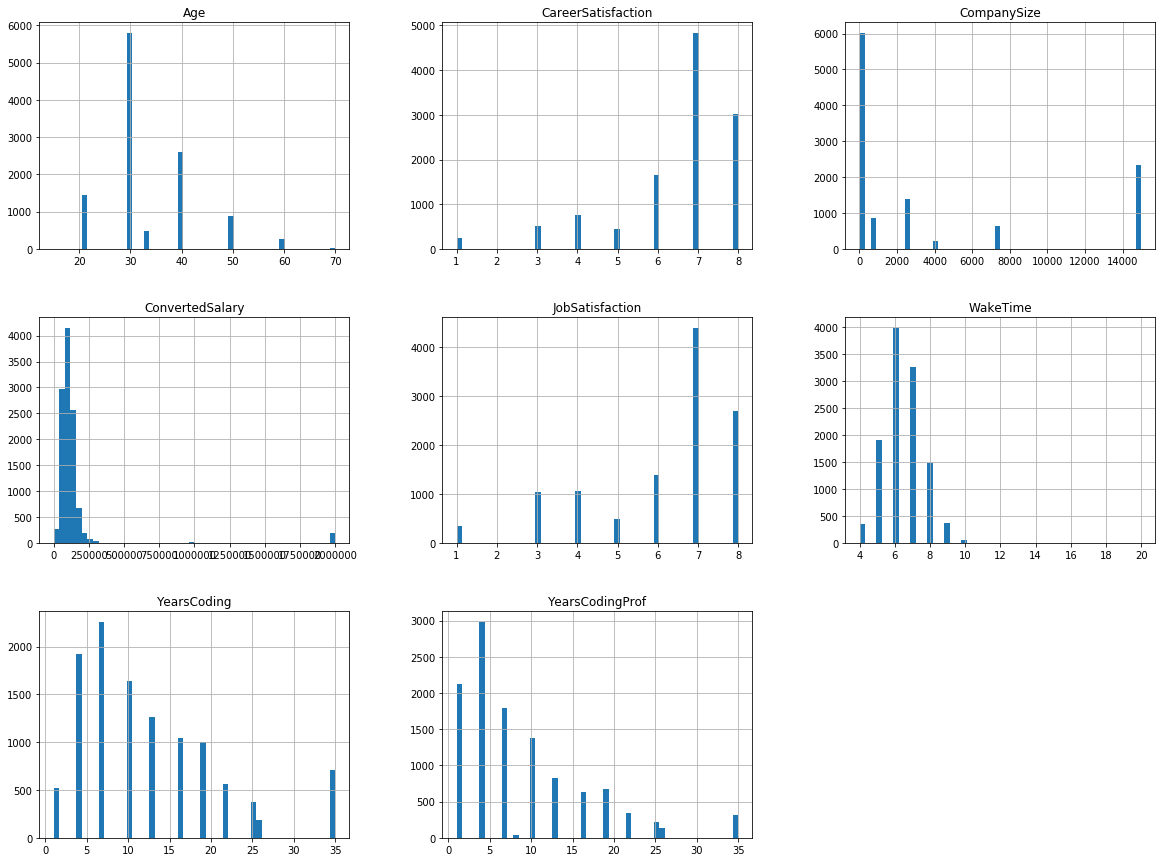

In [31]:
# lets check the histograms of our non binary columns
final_data[non_binary_columns].hist(bins=50, figsize=(20,15))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11E4E390>,
      dtype=object)

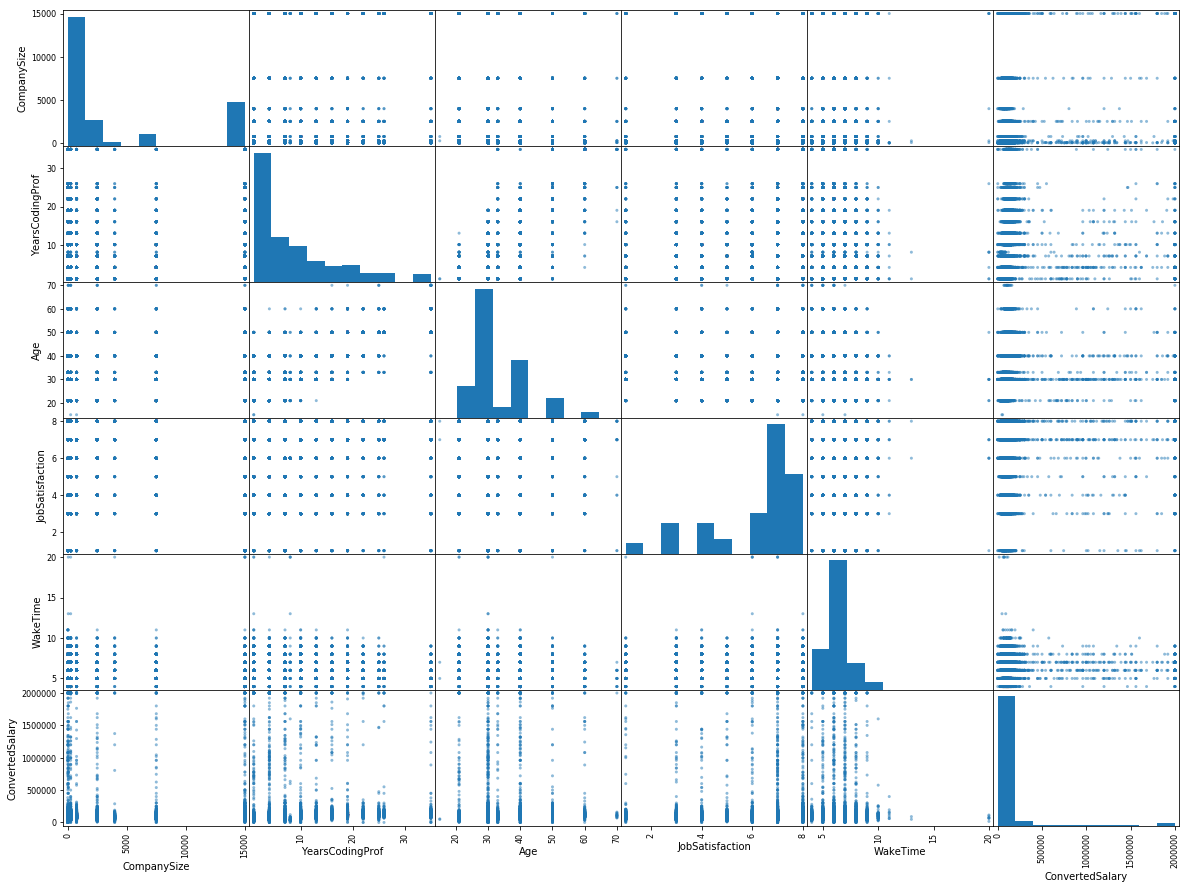

In [32]:
# now lets draw combined scatters to observe correlations
from pandas.plotting import scatter_matrix
attributes = [
    'CompanySize',
    'YearsCodingProf',
    'Age',
    'JobSatisfaction',
    'WakeTime',
    'ConvertedSalary'
]
scatter_matrix(final_data[attributes], figsize=(20, 15))

Currently, from the scatters, it doesnt seem - any correlation between the compared columns exists
lets check correlation values

In [33]:
scatter_table = final_data[attributes]
corr_matrix = scatter_table.corr()
corr_matrix["ConvertedSalary"].sort_values(ascending=False)

ConvertedSalary    1.000000
YearsCodingProf    0.050611
CompanySize        0.046351
Age                0.035187
WakeTime           0.006207
JobSatisfaction   -0.004904
Name: ConvertedSalary, dtype: float64

As we expected - no strong correlation was found to our non binary values

In [34]:
# lets briefly review our data-set for NaNs & numerical attributes
nan_stats_with_summary(final_data)

NaN values in DataFrame: [0/1043679] - [0.00%]


,category,count,%
0,CompanySize,0,0.0
1,YearsCoding,0,0.0
2,YearsCodingProf,0,0.0
3,Age,0,0.0
4,JobSatisfaction,0,0.0
5,CareerSatisfaction,0,0.0
6,WakeTime,0,0.0
7,ConvertedSalary,0,0.0
8,OS_Linux-based,0,0.0
9,OS_MacOS,0,0.0


In [35]:
pd.set_option('display.max_rows', 300)
final_data.describe().T[['min', 'max', 'mean']]

,min,max,mean
CompanySize,5.0,15000.0,3971.935478
YearsCoding,1.0,35.0,12.538495
YearsCodingProf,1.0,35.0,8.892406
Age,15.0,70.0,33.537972
JobSatisfaction,1.0,8.0,6.194612
CareerSatisfaction,1.0,8.0,6.534571
WakeTime,4.0,20.0,6.451129
ConvertedSalary,0.0,2000000.0,158534.887872
OS_Linux-based,0.0,1.0,0.156334
OS_MacOS,0.0,1.0,0.385387


In [36]:
pd.reset_option('display.max_rows')

it look like our data is almost ready to be learned,

we still need to scale the data to similar ranges (Min-Max/Standardization)

## Pipelining - Data preparations

### Design:

In [10]:
# Lets design A pipe-line to perform all of our manual work
# and to take care of value scaling
local_file = FileLink("./Diagrams/ch2/data_preparations_diagram.svg")
display(local_file)

D:\ml\Diagrams\ch2\data_preparations_diagram.svg

### Assembly:

In [38]:
categorical = ['OperatingSystem', 'UndergradMajor']   # need to add gender after trans.
multi_categorical = ['DevType', 'LanguageWorkedWith', 'RaceEthnicity']
boolean_cols = ['OpenSource']
num_cols = ['CompanySize', 'YearsCoding', 'YearsCodingProf', 'Age',
            'JobSatisfaction', 'CareerSatisfaction', 'WakeTime']

all_columns = [c for c in WORK_COLUMNS if c not in ['Country','Employment', 'ConvertedSalary']]

# this pipeline works with data frames instead of ndarrays
col_val_filter_params = [
    ['Country', 'Employment', 'OperatingSystem'],
    ['United States', 'Employed full-time', 'BSD/Unix'],
    [True, True, False]
]

# (1-4)
clean_up_pipeline = Pipeline([
        ('selector', DataFrameCopySelector(WORK_COLUMNS)),              #(1)
        ('nan_filter', ColumnBasedNanFilter(nan_cleanup_columns)),      #(2)
        ('col_val_filter', ColumnValueFilter(*col_val_filter_params)),  #(3)
        ('del_cols', DataFrameColumnOmiter(['Country', 'Employment'])), #(4)
])

# this pipe line does simple, and column specific transformations
# ---------------------------------------------------------------------------
# (6-7)
repl_non_matching = DataFrameReplaceNonMatching(['Male', 'Female'], 'Other')
repl_in_cols_by_dict = DataFrameReplaceInColsByDict(int_range_as_str, name_to_conversion_dict)

simple_conversions_pipeline = ColumnTransformer([
    ('gender', repl_non_matching, 'Gender'),                           # (6)
    ('str_to_int', repl_in_cols_by_dict, int_range_as_str),            # (7)
], remainder='passthrough')

transformed_headers = ['Gender'] + int_range_as_str
remainder_cols = [ c for c in all_columns if c not in transformed_headers]
headers_to_be = transformed_headers + remainder_cols

categorical.append('Gender')   # after above trans. gender is also cat.

# ---------------------------------------------------------------------------

# (11-12)
num_pipe_line = Pipeline([
    ('fill_nan', Imputer(strategy="median")),
    ('std_scaler', StandardScaler())
])

# (8-14)
major_pipe_line = ColumnTransformer([
    ('cat', OneHotEncoderWithNaNs(), categorical),                     #(9)
    ('multi_cat', OneHotEncoderWithNaNsMulti(';'), multi_categorical), #(10)
    ('numerical', num_pipe_line, num_cols),                            #(11-12)
    ('boolean', ConvertStringToBool('Yes'), boolean_cols),             #(13)
])

### Execution:

In [39]:
clean_data = clean_up_pipeline.fit_transform(data)  # (1-4)

# (*):
train_data, test_data = train_test_split(
    clean_data, test_size=0.2, random_state=42)

work_data = train_data.drop('ConvertedSalary', axis=1)  # (5)
labels = train_data.loc[:, 'ConvertedSalary'].copy()  # (5,16)

work_data.head()

,OpenSource,UndergradMajor,CompanySize,DevType,YearsCoding,YearsCodingProf,OperatingSystem,Gender,Age,JobSatisfaction,CareerSatisfaction,LanguageWorkedWith,WakeTime,RaceEthnicity
Respondent,,,,,,,,,,,,,,
56330,Yes,Mathematics or statistics,"10,000 or more employees",Back-end developer;Front-end developer;Full-st...,6-8 years,3-5 years,Windows,Male,18 - 24 years old,Moderately satisfied,Moderately satisfied,Java;JavaScript;TypeScript;HTML;CSS,Between 8:01 - 9:00 AM,White or of European descent
83279,Yes,"A social science (ex. anthropology, psychology...",20 to 99 employees,Back-end developer,3-5 years,0-2 years,MacOS,Female,35 - 44 years old,Extremely satisfied,Extremely satisfied,C;Go;Java;Python;SQL;HTML;CSS,Between 6:01 - 7:00 AM,White or of European descent
24399,No,"Computer science, computer engineering, or sof...","10,000 or more employees",NaN,24-26 years,24-26 years,NaN,Male,45 - 54 years old,Moderately dissatisfied,Moderately dissatisfied,Assembly;C;C++;Java;Perl,Between 7:01 - 8:00 AM,White or of European descent
77596,No,"Computer science, computer engineering, or sof...",Fewer than 10 employees,Back-end developer;DevOps specialist,9-11 years,6-8 years,MacOS,Male,25 - 34 years old,Moderately satisfied,Extremely satisfied,Java;JavaScript;PHP;Python;Ruby;SQL;HTML;CSS;B...,Between 8:01 - 9:00 AM,Middle Eastern
66005,No,"A natural science (ex. biology, chemistry, phy...","5,000 to 9,999 employees",Back-end developer;Desktop or enterprise appli...,3-5 years,3-5 years,Windows,Male,25 - 34 years old,Moderately satisfied,Slightly satisfied,C#;JavaScript;Python;TypeScript;Visual Basic 6...,Between 9:01 - 10:00 AM,South Asian


In [40]:
after_simple = pd.DataFrame(
    data=simple_conversions_pipeline.fit_transform(work_data),
    columns=headers_to_be
)
after_simple.head()

,Gender,CompanySize,YearsCoding,YearsCodingProf,Age,JobSatisfaction,CareerSatisfaction,WakeTime,OpenSource,UndergradMajor,DevType,OperatingSystem,LanguageWorkedWith,RaceEthnicity
0,Male,15000,7,4,21,7,7,8,Yes,Mathematics or statistics,Back-end developer;Front-end developer;Full-st...,Windows,Java;JavaScript;TypeScript;HTML;CSS,White or of European descent
1,Female,50,4,1,40,8,8,6,Yes,"A social science (ex. anthropology, psychology...",Back-end developer,MacOS,C;Go;Java;Python;SQL;HTML;CSS,White or of European descent
2,Male,15000,25,25,50,3,3,7,No,"Computer science, computer engineering, or sof...",NaN,NaN,Assembly;C;C++;Java;Perl,White or of European descent
3,Male,5,10,7,30,7,8,8,No,"Computer science, computer engineering, or sof...",Back-end developer;DevOps specialist,MacOS,Java;JavaScript;PHP;Python;Ruby;SQL;HTML;CSS;B...,Middle Eastern
4,Male,7500,4,4,30,7,6,9,No,"A natural science (ex. biology, chemistry, phy...",Back-end developer;Desktop or enterprise appli...,Windows,C#;JavaScript;Python;TypeScript;Visual Basic 6...,South Asian


In [41]:
after_major = pd.DataFrame(major_pipe_line.fit_transform(after_simple),
                           columns=(OneHotEncoderWithNaNs.last_categories + 
                           OneHotEncoderWithNaNsMulti.last_categories) +
                           num_cols +
                           boolean_cols)

all_required_columns = after_major.columns.tolist()

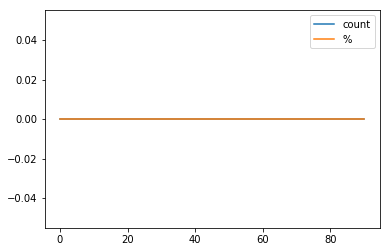

In [42]:
# check if anything is NaN
nan_stats(after_major).plot()

In [43]:
# whole pipeline - currently as function:
def full_pipeline(data_frame):

    after_simple = pd.DataFrame(
        data=simple_conversions_pipeline.fit_transform(data_frame),
        columns=headers_to_be)

    after_major = pd.DataFrame(
        major_pipe_line.fit_transform(after_simple),
        columns=(OneHotEncoderWithNaNs.last_categories +
                 OneHotEncoderWithNaNsMulti.last_categories) + num_cols +
        boolean_cols)
    
    return add_missing_columns(after_major, all_required_columns, 0)

## Training models:

### Review the labels properties

In [44]:
pd.DataFrame(labels.describe().map(lambda x: '{:.0f}'.format(x)))

,ConvertedSalary
count,9175
mean,156184
std,283442
min,0
25%,75000
50%,100000
75%,130000
max,2000000


### Linear Regression

In [45]:
# Generate regressor
lin_reg = LinearRegression()
lin_reg.fit(after_major, labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [46]:
# verify quality:
some_data = work_data.iloc[:5]
some_labels = labels.iloc[:5]
some_data_prepared = full_pipeline(some_data)
some_data

C:\Users\Lev\AppData\Local\Programs\Python\Python36-32\lib\site-packages\pandas\core\indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


,OpenSource,UndergradMajor,CompanySize,DevType,YearsCoding,YearsCodingProf,OperatingSystem,Gender,Age,JobSatisfaction,CareerSatisfaction,LanguageWorkedWith,WakeTime,RaceEthnicity
Respondent,,,,,,,,,,,,,,
56330,Yes,Mathematics or statistics,"10,000 or more employees",Back-end developer;Front-end developer;Full-st...,6-8 years,3-5 years,Windows,Male,18 - 24 years old,Moderately satisfied,Moderately satisfied,Java;JavaScript;TypeScript;HTML;CSS,Between 8:01 - 9:00 AM,White or of European descent
83279,Yes,"A social science (ex. anthropology, psychology...",20 to 99 employees,Back-end developer,3-5 years,0-2 years,MacOS,Female,35 - 44 years old,Extremely satisfied,Extremely satisfied,C;Go;Java;Python;SQL;HTML;CSS,Between 6:01 - 7:00 AM,White or of European descent
24399,No,"Computer science, computer engineering, or sof...","10,000 or more employees",NaN,24-26 years,24-26 years,NaN,Male,45 - 54 years old,Moderately dissatisfied,Moderately dissatisfied,Assembly;C;C++;Java;Perl,Between 7:01 - 8:00 AM,White or of European descent
77596,No,"Computer science, computer engineering, or sof...",Fewer than 10 employees,Back-end developer;DevOps specialist,9-11 years,6-8 years,MacOS,Male,25 - 34 years old,Moderately satisfied,Extremely satisfied,Java;JavaScript;PHP;Python;Ruby;SQL;HTML;CSS;B...,Between 8:01 - 9:00 AM,Middle Eastern
66005,No,"A natural science (ex. biology, chemistry, phy...","5,000 to 9,999 employees",Back-end developer;Desktop or enterprise appli...,3-5 years,3-5 years,Windows,Male,25 - 34 years old,Moderately satisfied,Slightly satisfied,C#;JavaScript;Python;TypeScript;Visual Basic 6...,Between 9:01 - 10:00 AM,South Asian


In [47]:
some_labels

Respondent
56330     95000.0
83279     92000.0
24399    123000.0
77596     78000.0
66005    131000.0
Name: ConvertedSalary, dtype: float64

In [48]:
print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [139728. 119216. 219216. 155360. 179896.]
Labels: [95000.0, 92000.0, 123000.0, 78000.0, 131000.0]


In [49]:
# calac RMSE for the whole housing data frame
predictions = lin_reg.predict(after_major)
lin_mse = mean_squared_error(labels, predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

280665.5249829977

#### summary:
we see that our RMSE is big, lets try making our label spread abit more narrow without harming our dataset too much and see the effect

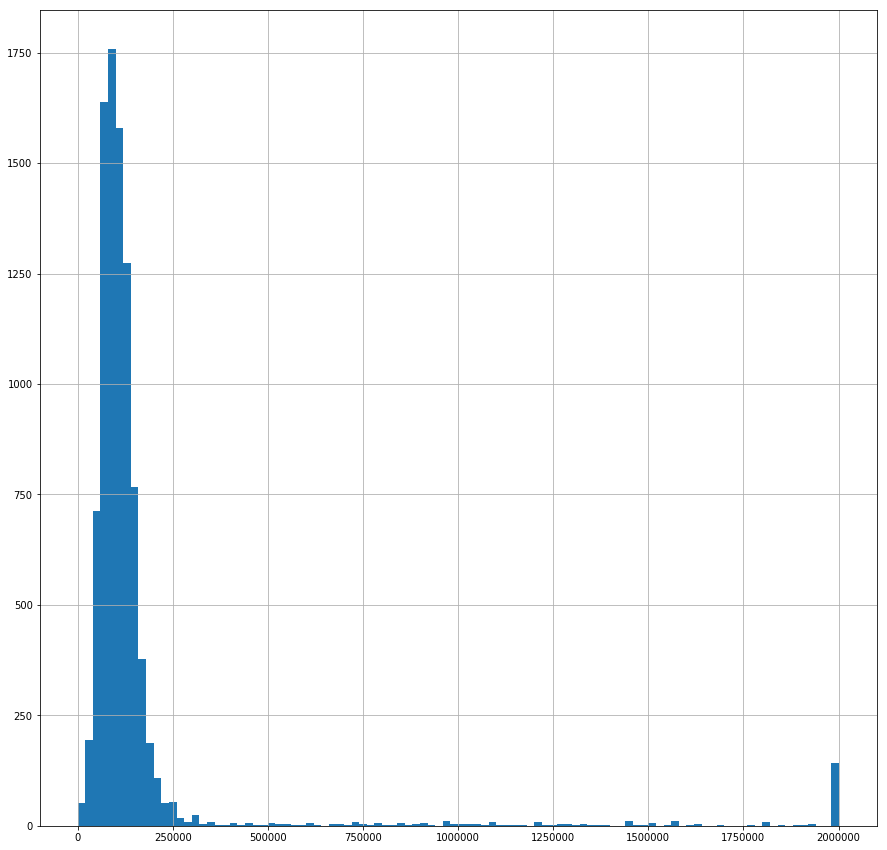

In [50]:
# lets see our label histogram:
labels.hist(bins=100, figsize=(15,15))

Over 500,000: 338
Over 250,000: 89


(<matplotlib.axes._subplots.AxesSubplot at 0x12515170>, count      8833.000000
 mean     104139.448432
 std       42346.612062
 min           0.000000
 25%       75000.000000
 50%      100000.000000
 75%      127000.000000
 max      250000.000000
 Name: ConvertedSalary, dtype: float64)

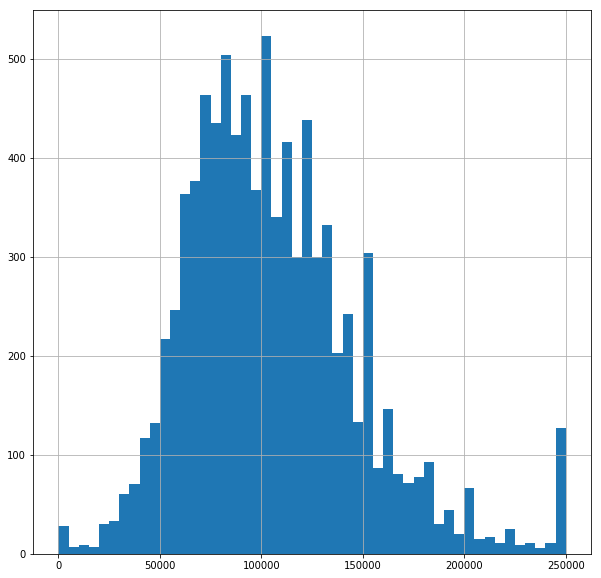

In [51]:
# we will remoeve data points with label > 500,000
# and reduce all with labels > 250,000 to  250,000 (after removal)

# copy data & labels
new_labels = labels.copy().reset_index(drop=True)
new_data = after_major.copy().reset_index(drop=True)


print('Over 500,000:', (new_labels > 500000).sum())

wanted_labels = (new_labels < 500000).copy()
new_labels = new_labels[wanted_labels]
new_data = new_data[wanted_labels]

print('Over 250,000:', (new_labels > 250000).sum())
new_labels[new_labels > 250000] = 250000

(new_labels.hist(bins=50, figsize=(10,10)), new_labels.describe())

In [52]:
# now learn again on the new data

# Generate regressor
lin_reg = LinearRegression()
lin_reg.fit(new_data, new_labels)

# calc RMSE for the whole housing data frame
predictions = lin_reg.predict(new_data)
lin_mse = mean_squared_error(new_labels, predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

32762.393589939416

* The Rmse dropped drastically - but still very big compared to the range of the labels

### Try other model: Random Forest regressor

In [53]:
forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(new_data, new_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [54]:
predictions = forest_reg.predict(new_data)
forest_mse = mean_squared_error(new_labels, predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

14304.794745055291

Great improvement! the mistake is smaller by a factor of more than 2

###  k-fold cross validation:
* we will randomly divide our data frame into K subsets
* the for K iterations we will:
    * select a subset - which will be the validation set
    * train our model against the other K-1
    * check predictions for the validation set
    * calc RMSE for each iteration

In [55]:
%%time
scores = cross_val_score(forest_reg, new_data, new_labels,
                         scoring="neg_mean_squared_error", cv=10)
# cross_val_score uses maximization function - the closer to 0 the better
# thus we need to negade the scores to get the MSE
tree_rmse_scores = np.sqrt(-scores)

Wall time: 10.2 s


In [56]:
display_scores(tree_rmse_scores)

Scores: [33842.26055356 35136.377288   34629.55578417 34819.16281095
 33621.97801837 32339.46192446 32881.47092366 34956.84660081
 33944.70164353 34519.98412945]
Mean: 34069.1799676958
Standard deviation: 876.1356073505727


In [57]:
%%time
# now lets perform kfold validation for linear regressor
lin_scores = cross_val_score(lin_reg, new_data, new_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [32743.02395903 33373.34462056 33777.01581116 33973.11355048
 33090.66915252 32480.22084759 32193.61919459 33762.7485564
 33401.95639244 32576.53465867]
Mean: 33137.22467434367
Standard deviation: 584.7340245475613
Wall time: 1.25 s


#### summary:
although from a first glance it looked like the random forest model performs better - after kfold validation - we discovered that both regressors perform about equally 

## Fine tune the model
* now we would like to fine tune our hyper-params
* because we dont want to explore the various hyper-params manually - we'll automize this procedure

### Grid Search
* this technique allows us to explore various combinations of hyper-params

In [58]:
%%time

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [50, 100, 200], 'max_features': [20, 30, 40, 50]},
    # then try 9 (3×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [50, 100, 200], 'max_features': [20, 30, 40]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+9)*5=105 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(new_data, new_labels)

Wall time: 10min 42s


In [59]:
grid_search.best_params_

{'max_features': 20, 'n_estimators': 200}

In [60]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=20, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [61]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

32402.737959830178 {'max_features': 20, 'n_estimators': 50}
32178.892746507958 {'max_features': 20, 'n_estimators': 100}
32103.86387730139 {'max_features': 20, 'n_estimators': 200}
32445.866339780325 {'max_features': 30, 'n_estimators': 50}
32219.384220914308 {'max_features': 30, 'n_estimators': 100}
32167.127812883813 {'max_features': 30, 'n_estimators': 200}
32467.98243597116 {'max_features': 40, 'n_estimators': 50}
32269.25343511643 {'max_features': 40, 'n_estimators': 100}
32223.47006419708 {'max_features': 40, 'n_estimators': 200}
32522.353093673726 {'max_features': 50, 'n_estimators': 50}
32366.650889495864 {'max_features': 50, 'n_estimators': 100}
32280.636109289066 {'max_features': 50, 'n_estimators': 200}
32439.728274590787 {'bootstrap': False, 'max_features': 20, 'n_estimators': 50}
32270.725181489 {'bootstrap': False, 'max_features': 20, 'n_estimators': 100}
32205.18732909088 {'bootstrap': False, 'max_features': 20, 'n_estimators': 200}
32721.715449555784 {'bootstrap': False

### Randomized search
* when we suspect that hyper-param search space is very big, sometimes we would want to explore it randomly, for a set number of iteration

In [62]:
%%time

param_distribs = {
    'n_estimators': randint(low=1, high=200),
    'max_features': randint(low=1, high=90),
}

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(
    forest_reg,
    param_distributions=param_distribs,
    n_iter=10,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=42)

rnd_search.fit(new_data, new_labels)

Wall time: 4min 10s


In [63]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

32324.826642526663 {'max_features': 52, 'n_estimators': 93}
32248.20435797848 {'max_features': 15, 'n_estimators': 107}
32374.712647158005 {'max_features': 72, 'n_estimators': 189}
32206.304691308957 {'max_features': 21, 'n_estimators': 103}
32541.45091861882 {'max_features': 83, 'n_estimators': 75}
32476.976891869086 {'max_features': 75, 'n_estimators': 88}
32166.84977802211 {'max_features': 24, 'n_estimators': 131}
32412.114774267193 {'max_features': 22, 'n_estimators': 53}
34011.191041242 {'max_features': 2, 'n_estimators': 88}
32576.867082908615 {'max_features': 30, 'n_estimators': 38}


In [74]:
# print most important features in our model:
feature_importances = grid_search.best_estimator_.feature_importances_
sorted(zip(feature_importances, new_data.columns), reverse=True)[:10]

[(0.14163515559594633, 'YearsCodingProf'),
 (0.10325712517725666, 'YearsCoding'),
 (0.05292721946855386, 'CompanySize'),
 (0.040857026561076835, 'Age'),
 (0.03470116755399406, 'WakeTime'),
 (0.032562229614388094, 'CareerSatisfaction'),
 (0.03211344427343664, 'OperatingSystem_Windows'),
 (0.02949011429614931, 'JobSatisfaction'),
 (0.027783702496037403, 'DevType_Engineering manager'),
 (0.018209727967246056, 'LanguageWorkedWith_PHP')]

## Test the model on the data set aside

In [75]:
final_model = grid_search.best_estimator_

X_test = test_data.drop("ConvertedSalary", axis=1)
y_test = test_data["ConvertedSalary"].copy()

X_test_prepared = full_pipeline(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [76]:
final_rmse

328888.16507855215

## Summary:
* We cleaned our data-set into some subset - that was appropriate in dimension for learning
* we manually continued cleaning and learning the trends in our data
* after the manual exploration - we assembled a pipeline to automize this procedure
* We tried Linear-Reg. and Random-Forest as our learning models
* Later, we automized the procedure of finding the best hyper-params for our chosen model
* And finally, we tried our best model on our test data-set
* We conclude that the model's predictions weren't very precise 
* Because the main goal of this task was to get more closely familiar with the procedure of cleaning & learning some date - we wont continue in exploring more promising models/params this time

* See you next time in our ML adventure =)